In [1]:
import math as mth
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random    

In [2]:
#Zone di interesse (rappresentazione grafica)

S=[0,1]  
I=[0,1]

#Zone di transizione, recupero, fatalità

P_SI=0.03 #Percentuale da suscettibili a infetti
s=0.2
S0=[s,s+P_SI*(S[-1]-S[0])]

P_IR=0.04  #Percentuale da infetti a guariti
s=0.7
R=[s,s+P_IR*(I[-1]-I[0])]

P_IF=0.01 #Percentuale da infetti a deceduti
s=0.4
F=[s,s+P_IF*(I[-1]-I[0])]

In [3]:
# Parametri per la simulazione
N = 1000000    # Numero totale di iterazioni

ignore = 10000 #Transiente per eliminare la dipendenza dalle condizioni iniziali     

bins = 100 # Bin per gli istogrammi


In [4]:
#Definiamo la traiettoria associata alla mappa
def Traiettoria(u, r):
    if u < r:
        return u / r
    else:
        return (1 - u) / (1 - r)

In [5]:
# Istogrammi vuoti da riempire
hist_S = np.zeros(bins)
hist_I = np.zeros(bins)

#Contatori per le misure
count_S0,count_S1,count_I0,count_R,count_F,count_all = 0,0,0,0,0,0


#Definiamo una funzione che aggiorna i contatori una volta superato il transiente
def conta(n,x,y):
#x rappresenta la posizione dell'individuo nello spazio degli stati e la y rappresenta lo stato dell'individuo
  global count_S0,count_S1,count_I0,count_R,count_F,count_all
  global hist_S,hist_I
  global N,bins,ignore

  if n >= ignore:
    count_all += 1
    if y == 0:                              #Se suscettibile
      if S0[0] <= x < S0[-1]:               #Se positivo al''infezione aggiunge valore al contatore di S0
          count_S0+=1
      elif 0<=x<=1:                         #Se non positivo ma solo suscettibile aggiunge valore al contatore di S1
          count_S1+=1
      hist_S[min(int(x*bins), bins-1)] += 1 #Traduco la x al bin che gli associo facendo x*bins e lo inserisco nel bin corrispondente
    else:                                   #Se infetto
      if R[0] <= x < R[-1]:                 #Se guarisce aggiunge valore al contatore di R
          count_R += 1
      elif F[0] <= x < F[-1]:               #Se decede aggiunge valore al contatore di F
          count_F += 1
      else:
          count_I0 += 1                     #Se solamente infetto aggiunge valore al contatore di I0
      hist_I[min(int(x*bins), bins-1)] += 1 #Traduco la x al bin che gli associo facendo x*bins e lo inserisco nel bin corrispondente

In [6]:
#Se voglio tener conto di immunita e decessi

def aggiorna(x,y):
  # Calcolo il valore successivo di x con la dinamica scelta e aggiorno
  x_next = Traiettoria(x, r)

  if y == 0:  # S
        y_next = 1 if S0[0] <= x < S0[-1] else 0
  else:       # I
      y_next = 0 if R[0] <= x < R[-1] or F[0] <= x < F[-1] else 1

  return x_next,y_next

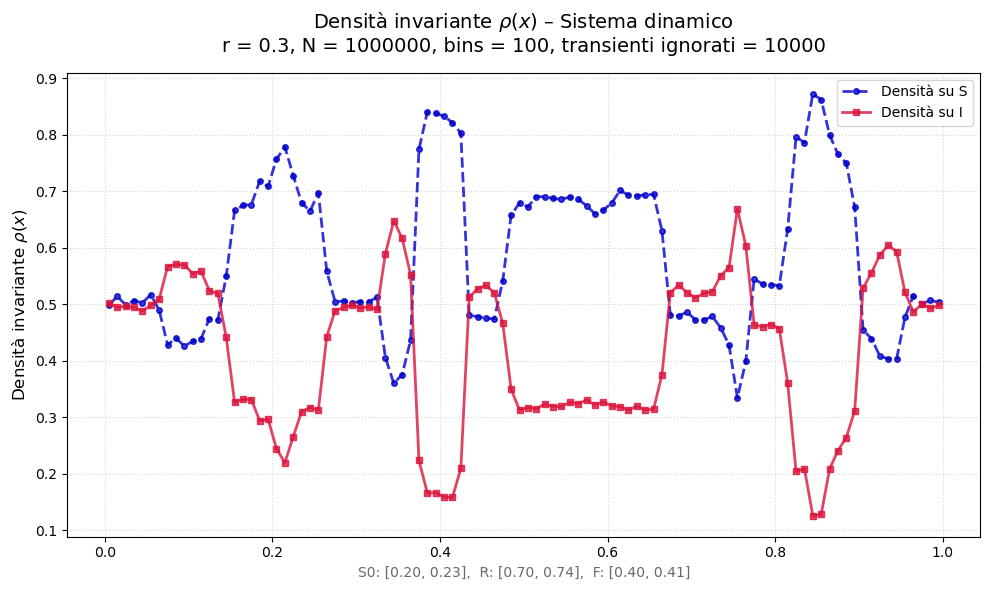

Stime delle misure l(E): 
μ(S0) ≈ 0.022622
μ(S1) ≈ 0.563037
μ(I0) ≈ 0.391718
μ(R)  ≈ 0.021031
μ(F)  ≈ 0.001591
Somma ≈ 1.000000


In [7]:
r = 0.3
x =np.random.rand()  # Condizione iniziale per x generata casualmente
y = 0

# Aggiorna i contatori e gli istogrammi ignorando il transiente e controllando
# la regione in cui si trova (x, y)
for n in range(N):
    conta(n,x,y)
    x,y=aggiorna(x,y)

# Risultati normalizzati (misure)
μ_S0,μ_S1,μ_I0,μ_R,μ_F  = count_S0 / count_all,count_S1 / count_all,count_I0 / count_all,count_R / count_all,count_F / count_all
# Densità invariante
dx = 1.0 / bins
μ_S = μ_S0 + μ_S1
μ_I = μ_I0 + μ_R + μ_F

total_S = hist_S.sum()
total_I = hist_I.sum()

# Controllo esplicitamente di non star dividendo per zero nel caso di bin vuoti
if total_S > 0:
    ρ_S = hist_S / total_S * μ_S / dx             
else:
    print("Nessuna visita in S dopo il transiente. Imposto ρ_S a zero.")
    ρ_S = np.zeros_like(hist_S, dtype=float)

if total_I > 0:
    ρ_I = hist_I / total_I * μ_I / dx
else:
    print("Nessuna visita in I dopo il transiente. Imposto ρ_I a zero.")
    ρ_I = np.zeros_like(hist_I, dtype=float)


# Costruzione dei bordi dei bin e dei centri
edges = np.linspace(0, 1, bins + 1)
x_centers = 0.5 * (edges[:-1] + edges[1:])

# Plot della densità invariante 
plt.figure(figsize=(10, 6))

plt.plot(x_centers, ρ_S, label="Densità su S", 
         color='mediumblue', linewidth=2, linestyle='--', marker='o', markersize=4, alpha=0.8)

plt.plot(x_centers, ρ_I, label="Densità su I", 
         color='crimson', linewidth=2, linestyle='-', marker='s', markersize=4, alpha=0.8)

# Etichette e titoli
plt.xlabel(r"$x \in [0,1]$", fontsize=12)
plt.ylabel(r"Densità invariante $\rho(x)$", fontsize=12)
plt.title(f"Densità invariante $\\rho(x)$ – Sistema dinamico\n"
          f"r = {r}, N = {N}, bins = {bins}, transienti ignorati = {ignore}", fontsize=14, pad=15)

# Informazioni extra nel grafico
plt.xlabel(f"S0: [{S0[0]:.2f}, {S0[-1]:.2f}],  R: [{R[0]:.2f}, {R[-1]:.2f}],  F: [{F[0]:.2f}, {F[-1]:.2f}]", 
             fontsize=10, y=1, color='dimgray')

# Griglia e legenda
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend(loc="upper right", frameon=True, fontsize=10)
plt.tight_layout()

plt.savefig("Densità invariante.png")
plt.show()
print("Stime delle misure l(E): ")
print(f"μ(S0) ≈ {μ_S0:.6f}")
print(f"μ(S1) ≈ {μ_S1:.6f}")
print(f"μ(I0) ≈ {μ_I0:.6f}")
print(f"μ(R)  ≈ {μ_R:.6f}")
print(f"μ(F)  ≈ {μ_F:.6f}")
print(f"Somma ≈ {μ_S0 + μ_S1 + μ_I0 + μ_R + μ_F:.6f}")


In [8]:
def Simulazione(M, N):
    x = np.random.rand(M)       #Generiamo parametri casuali in [0,1] per le condizioni iniziali
    y = np.zeros(M, dtype=int)  #GLi M individui partono come suscettibili

    for j in range(M):          #Evolviamo il sistema secondo la dinamica per M individui e N iterazioni 
      for i in range(N):
          x_next=Traiettoria(x[j], r)
          if y[j]==0:  # Suscettibili
             y_next= 1 if S0[0]<=x[j]<S0[-1] else 0
          else:       # Infetti
             y_next = 0 if R[0]<=x[j]<R[-1] or F[0]<=x[j]<F[-1] else 1

 #Aggiorno le variabili in funzione della traiettoria
          x[j], y[j]=x_next, y_next
          
 #Associo le z alle variabili aggiornate
    z=x+y

#Ordino z crescente e costruisco un funzione di ripartizione
    z_ord=np.sort(z)
    f=np.arange(1, M + 1)/M
    return z_ord, f

In [9]:
def Stima(N, t, bins):
    x = np.random.rand()
    y = 0

    # Genera un istogramma su z ∈ [0,2)
    edges=np.linspace(0.0, 2.0, bins + 1)
    hist=np.zeros(bins, dtype=float)

    for n in range(N):
        if n>=t:
        #Dopo il transiente calcolo z
            z=x+y
        # Bin di z in [0,2), restituisce l'indice del bin
            b=int(np.floor((z / 2.0) * bins))
            if b == bins:
                b=bins-1 #Controllo di non sforare nel caso x=1
            hist[b]+=1.0 #Conto quante volte la traiettoria cade in b

        # Passo di dinamica
        x_next=Traiettoria(x, r)
        if y == 0:  # S
            y_next= 1 if S0[0]<=x<S0[-1] else 0
        else:       # I
            y_next = 0 if R[0]<=x<R[-1] or F[0]<=x<F[-1] else 1
        x,y=x_next,y_next

    # Normalizzo ad una densità su z (area ~ 1) e faccio la funzione di
    # ripartizione
    dz=edges[1]-edges[0] #Larghezza bin
    #densità prob. di essere in z
    dens=(hist/hist.sum())/dz #Normalizzo rispetto a z
    Fl=np.cumsum(dens)*dz #Faccio la somma cumulata sull'array dens
    centri= 0.5*(edges[:-1] + edges[1:]) #Centri istogramma
    return centri, Fl

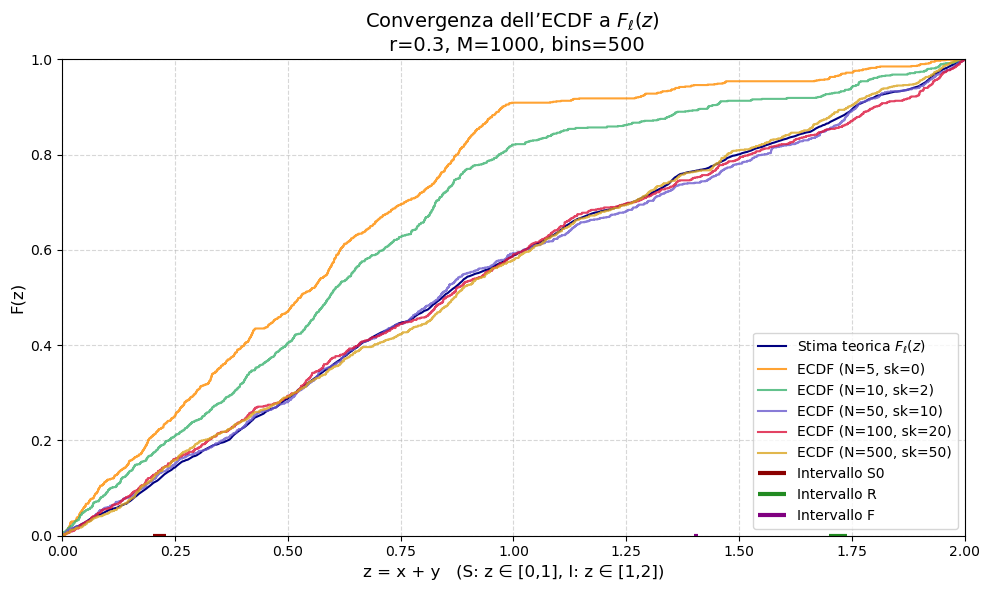

In [10]:
#Parametri della simulazione
n_condizioni_iniziali = 1000  # Numero di condizioni iniziali
n_bins = 500                  # Risoluzione della griglia per F_l(z)

# Diverse combinazioni di iterazioni e transienti
n_iterazioni = [5, 10, 50, 100, 500]
transienti = [0, 2, 10, 20, 50]

#Stima teorica di F_l(z) con grandi numeri di iterazioni
z_griglia, Fl_teorica = Stima(10000, 2000, n_bins)
plt.figure(figsize=(10, 6))

# Curva teorica di riferimento (in blu scuro)
plt.plot(z_griglia, Fl_teorica, color="navy", lw=1.5, label="Stima teorica $F_\\ell(z)$")

#Ciclo su diversi N e transienti per confronto empirico
colori = ['darkorange', 'mediumseagreen', 'slateblue', 'crimson', 'goldenrod']

for idx in range(len(n_iterazioni)):
    N = n_iterazioni[idx]
    sk = transienti[idx]

    # Calcolo ECDF empirica per N iterazioni
    z_ordinati, Fl_empirica = Simulazione(n_condizioni_iniziali, N)

    # Traccia ECDF con un colore diverso per ogni coppia (N, sk)
    plt.step(z_ordinati, Fl_empirica, where="post", alpha=0.8,
             label=f"ECDF (N={N}, sk={sk})", color=colori[idx])

#Linee orizzontali per evidenziare zone critiche su y=0
# Nota: questi valori devono essere definiti nel contesto (S0, R, F)
plt.hlines(y=0, xmin=S0[0], xmax=S0[1], color='darkred', lw=3, label="Intervallo S0")
plt.hlines(y=0, xmin=R[0]+1, xmax=R[1]+1, color='forestgreen', lw=3, label="Intervallo R")
plt.hlines(y=0, xmin=F[0]+1, xmax=F[1]+1, color='purple', lw=3, label="Intervallo F")

# Etichette, titolo, limiti e legenda
plt.xlabel("z = x + y   (S: z ∈ [0,1], I: z ∈ [1,2])", fontsize=12)
plt.ylabel("F(z)", fontsize=12)
plt.title(f"Convergenza dell’ECDF a $F_\\ell(z)$ \n r={r}, M={n_condizioni_iniziali}, bins={n_bins}", fontsize=14)

plt.legend(loc='lower right', fontsize=10)
plt.xlim(0, 2)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("ECDF.png")
plt.show()


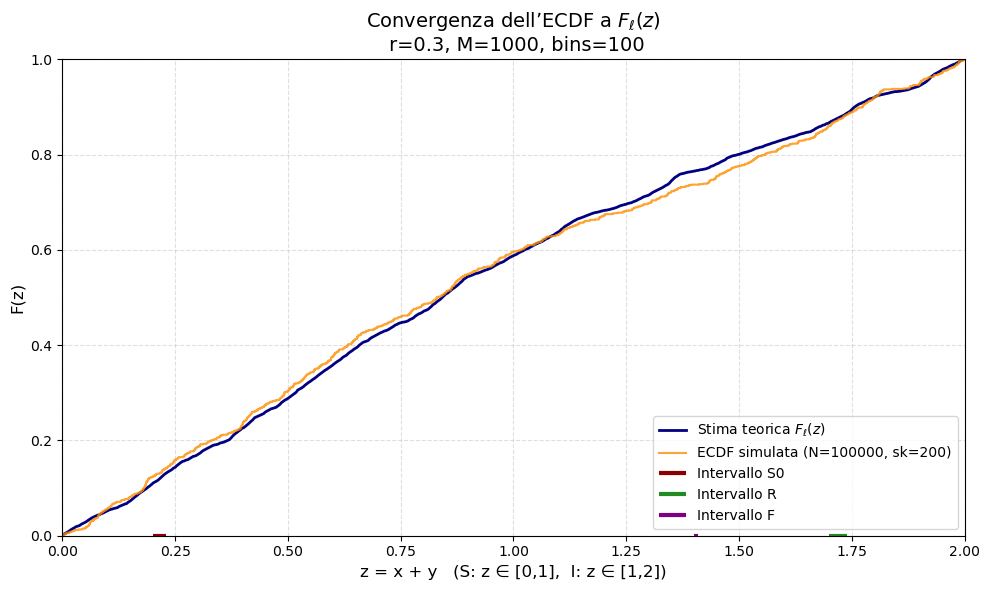

In [11]:
# Visualizzazione confronto tra ECDF e stima teorica F_l(z)

plt.figure(figsize=(10, 6))

# Curva teorica stimata (linea continua blu scuro)
plt.plot(z_griglia, Fl_teorica, color="navy", lw=2, label="Stima teorica $F_\\ell(z)$")

# Parametri di simulazione per confronto empirico
n_iterazioni = 100000
transienti = 200

# ECDF campionaria della popolazione dopo n_iter iterazioni
z_ord, eFl = Simulazione(n_condizioni_iniziali, n_iterazioni)

# Aggiunta curva ECDF simulata (linea a gradini arancione)
plt.step(z_ord, eFl, where="post", alpha=0.8,
         color='darkorange', label=f"ECDF simulata (N={n_iterazioni}, sk={transienti})")

plt.hlines(y=0, xmin=S0[0], xmax=S0[1], color='darkred', lw=3, label="Intervallo S0")
plt.hlines(y=0, xmin=R[0]+1, xmax=R[1]+1, color='forestgreen', lw=3, label="Intervallo R")
plt.hlines(y=0, xmin=F[0]+1, xmax=F[1]+1, color='purple', lw=3, label="Intervallo F")

# Etichette e titolo
plt.xlabel("z = x + y   (S: z ∈ [0,1],  I: z ∈ [1,2])", fontsize=12)
plt.ylabel("F(z)", fontsize=12)
plt.title(f"Convergenza dell’ECDF a $F_\\ell(z)$\n r={r}, M={n_condizioni_iniziali}, bins={bins}", fontsize=14)

# Legenda e limiti
plt.legend(loc='lower right', fontsize=10)
plt.xlim(0, 2)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("Fl.png")
plt.show()


In [12]:
def lyapunov(N, transienti, r):

    x=np.random.rand()
    y=0

    logs_sum=0.0  #Somma dei log |f'(x)|

#Calcolo log |f'(x)| dopo il transiente
    for n in range(N):
        if n >= transienti:
# Specifico quale mappa utilizzare in funzione dei valori di x
            if x<r:
                logs=np.log(1.0/r)
            else:
                logs=np.log(1.0/(1.0-r))
            logs_sum+=logs

#Applico la mappa alle x
        x_next=Traiettoria(x, r)
        if y == 0:  # S
          y_next=1 if S0[0]<= x<S0[-1] else 0
        else:       # I
          y_next = 0 if R[0]<=x<R[-1] or F[0]<=x<F[-1] else 1
        x,y=x_next,y_next
        
        λ=logs_sum/N

    return λ

In [13]:
λ = lyapunov(N, transienti, r)

print(f"r = {r:.3f}")
print(f"λ ≈ {λ:.6f}")

# Valore teorico calcolato a partire dall'integrale della derivata della mappa 
λ_teorico=r*np.log(1.0 / r)+(1.0 - r)*np.log(1.0/(1.0 - r))
print(f"λ_teorico = {λ_teorico:.6f}")
print(f"Δ = λ - λ_teorico = {λ - λ_teorico:.6e}")

r = 0.300
λ ≈ 0.376686
λ_teorico = 0.610864
Δ = λ - λ_teorico = -2.341781e-01
